In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

# import

In [2]:
# export
from fastai.basic_train import LearnerCallback

In [3]:
# export
from fastai.callbacks.general_sched import *
from fastai.callback import *

In [4]:
# export
from fastai.core import *

In [5]:
# export
from IPython.core import debugger as idb

In [6]:
from ..exp import nb_databunch
from ..exp import nb_resnet_ssd
from ..exp import nb_init_model
from ..exp import nb_anchors_loss_metrics
from ..exp import nb_optimizer
from ..exp import nb_tensorboard_callback

In [7]:
import torch

In [8]:
from fastai.basic_train import Learner

In [9]:
from functools import partial

In [10]:
import os,shutil

# functions

## CustomEpochLength(Callback)

In [11]:
# export
class CustomEpochLength(Callback):
    def __init__(self, epoch_len=1e99):
        '''
        在fastai定义的训练过程中，只有在一个epoch结束后才会进行一次valid loss和metrics计算。
        在数据集很大，batch size很小时，一个epoch包含的iteration数非常多，就会导致非常多的iteration后才会进行一次valid loss和metrics
        计算。这会是个问题，因为你往往根据valid loss或metrics来做一些决定，例如early stop，如果valid loss和metrics更新周期太长，可能
        会使你错过最好的时机。
        本callback使你能指定一个epoch包含更少的iteration.
        注意：如果你指定一个epoch包含更多的iteration，则实际上本callback是不起作用的。
        注意：如果你使用该callback，你要确定你的dataloader的sample方式是随机的，否则可能会导致每个epoch都只看到固定的一部分训练
        数据，而另一部分训练数据永远不会参与训练。
        ------------------------------------------------------
        参数：
        -- epoch_len：指定一个epoch包含多少个iteration，默认为一个非常大的数（1e99），这保证如果你使用了该callback但没有指定epoch_len，
        那么实际上该callback是不起作用的.
        '''
        self.epoch_len=epoch_len
        print('ALLERT: You are using CumtomEpochLength, please make sure that your training dataloader is using random sampler, or this may cause problem.')
        
    def on_batch_end(self, num_batch, **kwargs):
        if (num_batch+1)%self.epoch_len: return
        return {'stop_epoch': True}
            

## MultiAnneal_Scheduler

In [12]:
# export
class MultiAnneal_Scheduler(LearnerCallback):
    def __init__(self, 
                 learn,
                 base_lr_sched,
                 monitor='valid',
                 worseN_thres=3,
                 annealRate=5,
                 duration_thres=5,
                 annealIte=100,
                 phaseMaxN=3,
                 finetune_stop=0):
        '''
        将训练过程分为多个constant lr训练阶段，当一个训练阶段到达平台期后，以线性下降的方式将lr衰减一定倍率，然后进入
        下一个constant lr训练阶段，如此重复，直至最后一个训练到达平台期后结束训练。其中第一个训练阶段的lr由base_lr_sched决定。
        参数：
            -- learn：Learner对象
            -- base_lr_sched：一个对learn的lr做scheduling的对象，它应该是constant lr的方式。本类就是通过自适应地修改它来修改对learn的lr的scheduling方式。
            -- monitor：根据哪个损失值来判定是否达到平台期，字符串，可选'valid'或'train_smooth'。不论你选各个变量，监测周期都是一个epoch.
            -- worseN_thres：当有warseN_thres个epoch都没有出现更好的loss时，认为达到了平台
            -- annealRate：loss到达平台后，将当前使用的lr衰减至1/annealRate
            -- duration_thres：一个constant lr训练阶段至少持续duration_thres个epoch
            -- annealIte：lr衰减至lr/annealRate经历的iteration数
            -- phaseMaxN：至多phaseMaxN个训练阶段
            -- finetune_stop：一个整数，在某个train phase刚开始，其lr稳定后，决定是否结束微调，变为全模型学习。若为0，则不起作用，即整个训练
            过程维持开始的微调策略；若大于phaseMaxN，也不会起作用。
        '''
        super().__init__(learn)
        self.scheduler = base_lr_sched
        self.monitor = monitor
        self.worseN_thres = worseN_thres
        self.annealRate = annealRate
        self.duration_thres = duration_thres
        self.annealIte = annealIte
        self.phaseMaxN = phaseMaxN
        self.finetune_stop = finetune_stop
        
        
        self.best_loss = None
        self.worseN = 0
        self.phaseDuration = 0
        self.phaseN = 0
        self.expectConstantLr = False
        
        
    def _get_monitoring_loss(self,**kwargs):
        if self.monitor=='valid': loss = kwargs['last_metrics'][0]
        if self.monitor=='train_smooth': loss = kwargs['smooth_loss']
        return loss
    
    
    def _finetune_stop(self,iteration,**kwargs):
        if self.finetune_stop==self.phaseN:
            if isinstance(self.scheduler.start,Iterable) and len(self.scheduler.start)>1:
                self.scheduler.start[0] = self.scheduler.start[1]
                self.scheduler.end[0] = self.scheduler.end[1]
                print(f'at iteration {iteration}, stop finetune and begin to train entire model.')
                
    
    def on_epoch_end(self, epoch, num_batch, **kwargs):
        # 更新当前phase持续周期
        self.phaseDuration += 1
        
        loss = self._get_monitoring_loss(**kwargs)
        
        # 首次epoch
        if self.best_loss is None:
            self.best_loss = loss
            return
        
        # 更新best_loss, self.warseN
        if loss<self.best_loss:
            self.best_loss = loss
            self.worseN = 0
        else:
            self.worseN += 1
        
        # 若达到phase结束条件
        if self.phaseDuration>=self.duration_thres and self.worseN>=self.worseN_thres:
            # 复位 phaseDuration
            self.phaseDuration = 0 
            # 更新 phaseN
            self.phaseN += 1
            
            # 设置lr的线性下降阶段
            self.scheduler.start = self.scheduler.start
            self.scheduler.end = self.scheduler.start / self.annealRate
            self.scheduler.func = annealing_linear

            self.scheduler.n_iter = self.annealIte
            self.scheduler.n = 0

            print(f'on end of epoch#{epoch}: start annealing from {self.scheduler.start} to {self.scheduler.end}')

            # 如果不是最后一个phase
            if self.phaseN<self.phaseMaxN:
                # 使end稍降，n_iter稍增，防止下降结束后结束训练
                self.scheduler.end -= (self.scheduler.start - self.scheduler.end)/self.annealIte
                self.scheduler.n_iter += 1
                # 设置 self.expectConstantLr=True，使下降阶段临结束时换为恒lr训练
                self.expectConstantLr = True
            # 如果是最后一个phase，则等待下降结束后自动结束训练，无需额外处理
            
    def on_batch_end(self, **kwargs):
        # 如果正在等待下降阶段结束后开始恒lr训练，并且下降阶段已经到了马上结束的时候
        if self.expectConstantLr and self.scheduler.n==(self.scheduler.n_iter-1):
            self.expectConstantLr = False
            self.scheduler.start = self.scheduler.start / self.annealRate
            self.scheduler.end = self.scheduler.start
            self.scheduler.func = annealing_no
            
            self.scheduler.n_iter = 1e99 # 将 n_iter 设置为一个非常大的数，防止该phase自动结束
            self.scheduler.n = 0
            
            self._finetune_stop(**kwargs)

## fit_with_warmup_multiAnneal

In [13]:
# export
def fit_with_warmup_multiAnnealPlat(learn,
                                    epoch_len:int=10,
                                    num_epoch:int=100,
                                    
                                    lr_start:float=3e-4,
                                    lr_constant:float=3e-3,
                                    warmup_iter:int=10,
                                    
                                    monitor:str='valid',
                                    worseN_thres:int=3,
                                    annealRate:float=5,
                                    duration_thres:int=5,
                                    annealIte:int=200,
                                    phaseMaxN:int=3,
                                    finetune_stop=0,
                                    callbacks=None)->None:
    '''
    训练开始时先warmup，然后以constant lr训练，valid loss到达平台后衰减lr继续constant lr训练，
    如此直到设置的epoch上限，或者constant lr训练阶段数达到上限，结束训练。
    参数：
    -- learn：Learner对象
    -- epoch_len：设置一个epoch包含的iteration数，（见CustomEpochLength的定义）。
    -- num_epochs：训练epoch数上限
    
    -- lr_start：warmup起始lr
    -- lr_constant：warmup结束lr，也是phase0的constant lr
    -- warmup_iter：warmup持续iteration数
    
    -- worseN_thres：当有warseN_thres个epoch都没有出现更好的valid loss时，认为达到了平台
    -- annealRate：valid loss到达平台后，将当前使用的lr衰减至1/annealRate
    -- duration_thres：一个constant lr训练阶段至少持续duration_thres个epoch
    -- annealIte：lr衰减至lr/annealRate经历的iteration数
    -- phaseMaxN：至多phaseMaxN个训练阶段
    -- finetune_stop：一个整数，在某个train phase刚开始，其lr稳定后，决定是否结束微调，变为全模型学习。若为0，则不起作用，即整个训练
    过程维持开始的微调策略；若大于phaseMaxN，也不会起作用。
    '''
    # 先建一个基础scheduler
    phase0 = TrainingPhase(warmup_iter).schedule_hp('lr',(lr_start,lr_constant),annealing_cos) # warmup
    phase1 = TrainingPhase(len(learn.data.train_dl)*num_epoch-warmup_iter).schedule_hp('lr',lr_constant,annealing_no) # constant lr
    base_sched = GeneralScheduler(learn, [phase0, phase1])
    
    
    # 提取base_sched的constant lr部分，传入MultiAnneal_Scheduler，供其自适应调整
    lr_sched = phase1.scheds['lr']
    autoPhases = MultiAnneal_Scheduler(learn=learn,
                                       base_lr_sched=lr_sched,
                                       monitor=monitor,
                                       worseN_thres=worseN_thres,
                                       annealRate=annealRate,
                                       duration_thres=duration_thres,
                                       annealIte=annealIte,
                                       phaseMaxN=phaseMaxN,
                                       finetune_stop=finetune_stop)
    
    # 加入fit函数的callbacks中
    callbacks = listify(callbacks)
    callbacks.append(base_sched)
    callbacks.append(autoPhases)
    
    # 设置一个epoch包含的iteration数
    set_epochLen = CustomEpochLength(epoch_len=epoch_len)
    callbacks.append(set_epochLen)
    
    learn.fit(num_epoch, callbacks=callbacks)

# test

In [14]:
# 设置device
device = torch.device('cuda')

In [15]:
# databunch
data = nb_databunch.get_databunch(data_root='./data/tiny_ds_20200331',bs=64,device=device,cache=False) 

In [16]:
# model
model = nb_resnet_ssd.get_resnet18_ssd()
model.load_state_dict(torch.load('./models/resnet18_ssd_init.pth'));

In [17]:
# learner
learn = Learner(data,model)
if device.type=='cuda':
    learn.model = torch.nn.DataParallel(learn.model,device_ids=[0,1,2,3])

In [18]:
# 设置loss function
gvs,_,_,avs,_,_ = nb_anchors_loss_metrics.get_ga()
gaf = nb_anchors_loss_metrics.GridAnchor_Funcs(gvs,avs,device)
learn.loss_func = partial(nb_anchors_loss_metrics.yolo_L, gaf=gaf)

In [19]:
# 设置 optimizer
learn.opt_func = partial(nb_optimizer.SU_Adam,betas=(0.9,0.99))

In [20]:
# 添加metrics
learn.metrics += [partial(nb_anchors_loss_metrics.clas_L,gaf=gaf)]
learn.metrics += [partial(nb_anchors_loss_metrics.cent_L,gaf=gaf)]
learn.metrics += [partial(nb_anchors_loss_metrics.hw_L,gaf=gaf)]
learn.metrics += [partial(nb_anchors_loss_metrics.pConf_L,gaf=gaf)]
learn.metrics += [partial(nb_anchors_loss_metrics.nConf_L,gaf=gaf)]
learn.metrics += [partial(nb_anchors_loss_metrics.clas_acc,gaf=gaf)]
learn.metrics += [partial(nb_anchors_loss_metrics.cent_d,gaf=gaf)]
learn.metrics += [partial(nb_anchors_loss_metrics.hw_r,gaf=gaf)]

In [21]:
# tensorboard callback
# 指定tensorboard加载的总目录
log_root = './tb_log/'
# 先清空加载目录
if os.path.exists(log_root): shutil.rmtree(log_root)
os.mkdir(log_root)

log_dir = f'{log_root}run#5'
tbCb = nb_tensorboard_callback.TensorBoardCallback(
                               learn=learn,
                               log_dir=log_dir,
                               plot_net=True,
                               plot_loss=True,
                               metric_plots=[],
                               hyper_plots=['lr'],
                               hist_plots=['res_blocks.0.0.conv1.weight',                                
                                           'res_blocks.2.0.conv1.weight',
                                           'res_blocks.4.0.conv1.weight'],
                               hist_iters=12)

In [22]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


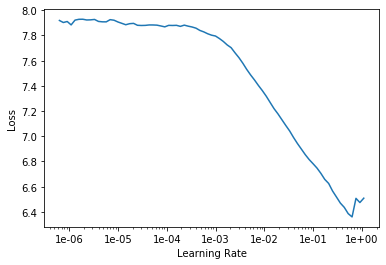

In [23]:
learn.recorder.plot()

In [24]:
# fit
fit_with_warmup_multiAnnealPlat(learn,
                                epoch_len=10,
                                num_epoch=100,

                                lr_start=3e-3,
                                lr_constant=3e-2,
                                warmup_iter=10,
                                
                                monitor='train_smooth',
                                worseN_thres=20,
                                annealRate=5,
                                duration_thres=20,
                                annealIte=10,
                                phaseMaxN=3,
                                callbacks=[tbCb])

ALLERT: You are using CumtomEpochLength, please make sure that your training dataloader is using random sampler, or this may cause problem.


epoch,train_loss,valid_loss,clas_L,cent_L,hw_L,pConf_L,nConf_L,clas_acc,cent_d,hw_r,time
0,6.401018,4.391027,2.026864,1.094021,0.372274,0.401282,0.496586,0.321400,0.007773,1.204626,00:38
1,5.718062,4.198907,1.718222,1.199870,0.461305,0.372082,0.447428,0.354552,0.008221,1.259477,00:39
2,5.151860,4.206512,1.819284,1.172115,0.414777,0.363091,0.437243,0.341353,0.008049,1.230669,01:15
3,4.857590,4.141801,1.823466,1.160300,0.364924,0.347988,0.445124,0.338166,0.008133,1.200265,01:57
4,4.653244,4.350423,1.951747,1.181375,0.427474,0.347231,0.442596,0.359559,0.008049,1.238804,01:48
5,4.468748,67.948242,46.136398,10.159351,10.862513,0.359006,0.430968,0.350505,0.041811,inf,01:32
6,4.424093,30.914713,19.232460,6.779490,4.113703,0.360668,0.428393,0.355735,0.020754,inf,00:37
7,4.369796,54.965199,40.565571,8.958403,4.653365,0.360704,0.427153,0.359781,0.022544,inf,01:32
8,4.393302,23.006367,15.626837,3.773280,2.782363,0.414052,0.409834,0.353553,nan,inf,01:28
9,4.368105,5.853026,3.256611,1.266098,0.541549,0.354894,0.433874,0.373737,0.008453,1.311540,01:19


KeyboardInterrupt: 

# export

In [7]:
!python notebook2script.py --fname 'scheduling_train.ipynb' --outputDir './exp/'

Converted scheduling_train.ipynb to exp/nb_scheduling_train.py
